In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("../data/btc.csv")

In [3]:
df = data[['date', 'adjClose', 'adjHigh', 'adjLow', 'adjOpen', 'adjVolume']]

In [4]:
df = df.rename(columns={"adjClose": "Close", "adjHigh": "High", "adjLow": "Low", "adjOpen": "Open", "adjVolume": "Volume"})

In [5]:
df

,date,Close,High,Low,Open,Volume
0,2011-08-19,10.900000,10.900000,10.900000,10.900000,0.490000
1,2011-08-20,11.690000,11.850000,11.150000,11.850000,1.930000
2,2011-08-21,11.700000,11.700000,11.700000,11.700000,0.090000
3,2011-08-22,11.700000,11.700000,11.700000,11.700000,0.090000
4,2011-08-23,11.700000,11.700000,11.700000,11.700000,0.030000
...,...,...,...,...,...,...
3446,2021-02-26,46294.658290,48436.054101,44101.606369,47081.564286,170559.033202
3447,2021-02-27,46131.220181,48388.877206,45010.531184,46284.902939,92096.048563
3448,2021-02-28,45172.971882,46649.244801,43020.789318,46127.402151,123050.435373
3449,2021-03-01,49597.682510,49796.076420,44981.741807,45167.027620,122510.109772


In [6]:
from sklearn.preprocessing import MinMaxScaler
price = df[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [7]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [8]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [9]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    

In [12]:
model_lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_lstm.parameters(), lr=0.01)

In [13]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model_lstm(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
#     print("Epoch ", t, "Mean Squared Error: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
# print("Training time: {}".format(training_time))

In [14]:
y_pred_lstm = model_lstm(x_test)


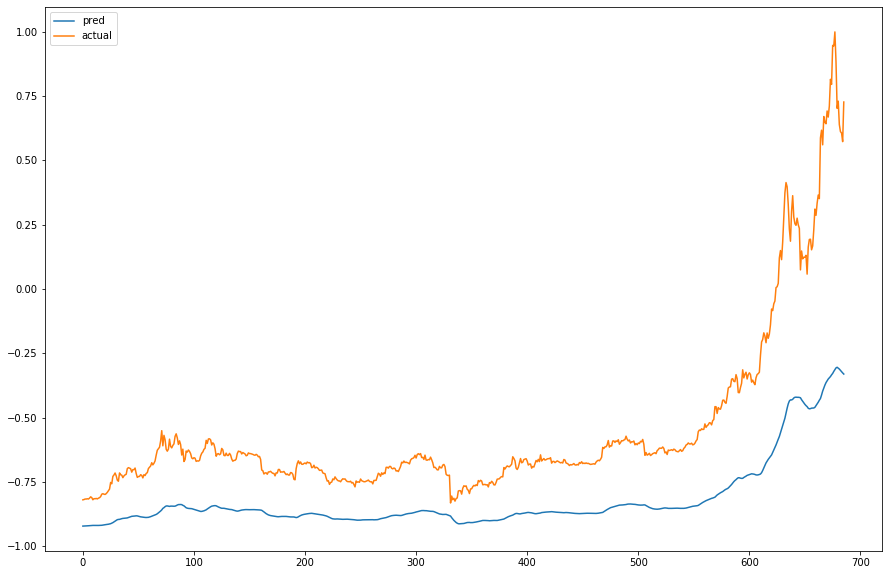

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(y_pred_lstm.detach().numpy(), label ='pred')
plt.plot(y_test, label ='actual')
plt.title('LSTM Prediction')
plt.legend(loc='best')

In [16]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [17]:
model_gru = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_gru.parameters(), lr=0.01)

In [18]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model_gru(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
#     print("Epoch ", t, "Mean Squared Error: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time

In [19]:
y_pred_gru = model_gru(x_test)

In [20]:
df.describe()

,Close,High,Low,Open,Volume
count,3451.000000,3451.000000,3451.000000,3451.000000,3451.000000
mean,4053.633027,4190.566685,3877.587350,4042.403997,37430.348478
std,6717.142225,6952.430737,6379.282516,6675.223190,48383.365448
min,2.240000,2.270000,2.220000,2.220000,0.030000
25%,232.995000,239.999000,226.500000,233.152500,5128.155000
50%,648.760000,666.300000,626.000000,650.000000,17025.380000
75%,6905.303491,7221.551980,6637.814234,6909.033381,55481.299836
max,57424.034546,58356.674988,55426.265543,57428.869519,633959.939587


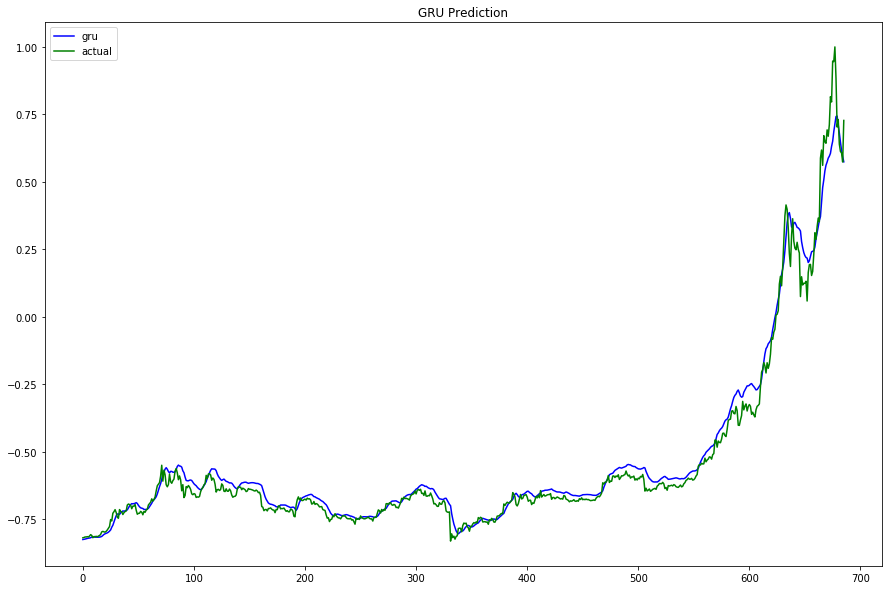

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(y_pred_gru.detach().numpy(), label ='gru', color='blue')
plt.plot(y_test, label ='actual', color='green')
plt.title('GRU Prediction')
plt.legend(loc='best')

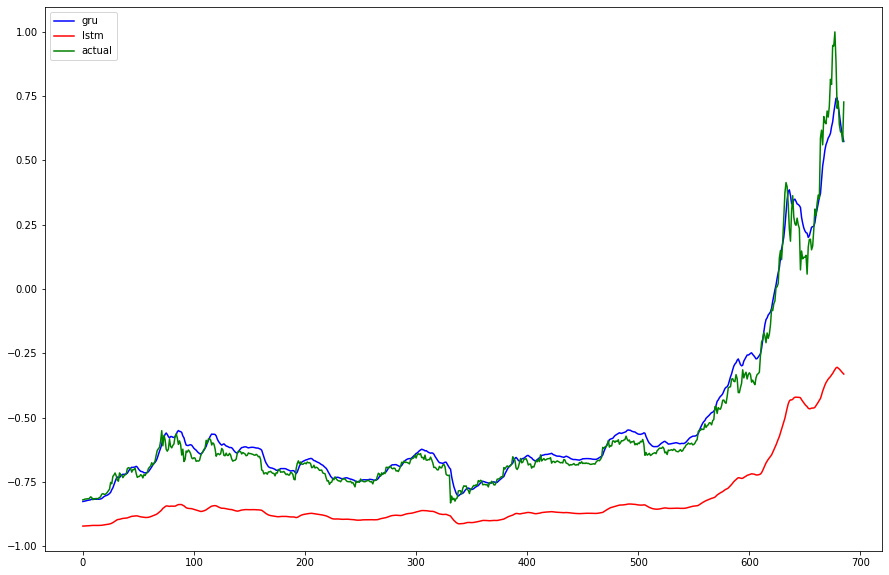

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(y_pred_gru.detach().numpy(), label ='gru', color='blue')
plt.plot(y_pred_lstm.detach().numpy(), label ='lstm', color=  'red')

plt.plot(y_test, label ='actual', color='green')
plt.legend(loc='best')